In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*pin_memory.*no accelerator.*"
)


#### A Notebook For Threat Hunting Using an Ensemble ML Model
Part of the DUNE project (https://github.com/opendr-io/dune) and useful for hunting threats that are resistant to conventional detection. This notebook does ensemble model anomaly detection using fields of your choice. The examples below are for analysis of CloudTrail logs. The notebook will run fourteen models by default; there are four more that can optionally be run which tend to take more time. The notebook will score each row in the dataframe according to how many models evaluated it as an outlier. The scored anomalous events can be queried, sifted, aggregated, and sorted using the tools at the end. The notebook uses the pyod package which is on Github at: https://github.com/yzhao062/pyod and has docs here: https://pyod.readthedocs.io/en/latest/pyod.models.html

In [72]:
import datetime
import pandas as pd
import pyod
import numpy as np
from numpy import percentile
import os
from random import randrange
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
import time
from time import time
import torch

In [3]:
from pyod.models.cblof import CBLOF
from pyod.models.cd import CD
from pyod.models.copod import COPOD
from pyod.models.dif import DIF
from pyod.models.ecod import ECOD
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.inne import INNE
from pyod.models.kde import KDE
from pyod.models.knn import KNN
from pyod.models.lmdd import LMDD
from pyod.models.loda import LODA
from pyod.models.lof import LOF
from pyod.models.lunar import LUNAR
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM 
from pyod.models.qmcd import QMCD
from pyod.models.rod import ROD
from pyod.models.sod import SOD

In [81]:
#variables
out_frac=0.001
random_state_number = 42
rs = np.random.RandomState(random_state_number)  #random state

In [8]:
# specify yourt data file or you can use the example data
csv_file_path = 'cloudtrail.csv'

In [79]:
# Read the file and extract relevant fields
raw = pd.read_csv(csv_file_path, encoding='utf-8')  # Adjust the encoding if needed
print('raw data shape and column names:')
print(raw.shape)
print()
print('Choose your field names:')
raw.columns

raw data shape and column names:
(25675, 9)

Choose your field names:


Index(['eventid', 'timestamp', 'sourceIPAddress', 'eventSource', 'eventName',
       'userAgent', 'userIdentity.arn', 'tactic1', 'tactic2'],
      dtype='object')

In [10]:
fields_to_encode = ['sourceIPAddress', 'eventSource',  'eventName', 'userAgent', 'userIdentity.arn'] 


In [11]:
# Select the columns you want to use for outlier detection
columns_for_outliers = ['sourceIPAddress', 'eventSource',  'eventName', 'userAgent', 'userIdentity.arn'] 


In [12]:
# dictionary of classifiers
# defines a dictionary of anomaly detection models with configurations
# using various algorithms from libraries likely associated with
# PyOD (Python Outlier Detection).
clf = { 
    'CBLOF': CBLOF(contamination=out_frac, check_estimator=False, random_state=rs),
    'IForest': IForest(contamination=out_frac,random_state=rs),
    'KNN': KNN(contamination=out_frac),
    'AvKNN': KNN(method='mean', contamination=out_frac),
    'LOF':LOF(n_neighbors=35, contamination=out_frac),
     ### added new ####
    'ROD':ROD(contamination=out_frac),
    'CD' : CD(contamination=out_frac),
    'COPOD' : COPOD(contamination=out_frac),
    'ECOD' : ECOD(contamination=out_frac),
    'GMM' : GMM(contamination=out_frac),
    'HBOS' : HBOS(contamination=out_frac),
    'INNE' : INNE(contamination=out_frac),
    'LODA' : LODA(contamination=out_frac),
    'QMCD' : QMCD(contamination=out_frac),
    # Optional classifiers; these will take longer to run
    #'OCSVM': OCSVM(contamination=out_frac), # One-class SVM 182 seconds
    #'DIF': DIF(contamination=out_frac), # 148 seconds
    #'KDE': KDE(contamination=out_frac), # 169 seconds
    #'LUNAR': LUNAR(contamination=out_frac), # 227 seconds i.e. 4 minutes
} 

In [14]:
df = raw.copy()
num_samples = df.shape[0]
fraction_of_inliers = (1. - out_frac) 
# (1 - fraction of outliers)
num_inliers = int(fraction_of_inliers * num_samples) 
# fraction of inliers * total number of samples
num_outliers = int(out_frac * num_samples) 
# fraction of outliers * total number of samples
print('No. of inliers: %i' % num_inliers)
print('No. of outliers: %i' % num_outliers)
print('dataframe shape:')
print(df.shape)

No. of inliers: 25649
No. of outliers: 25
dataframe shape:
(25675, 9)


In [15]:
def validate_raw_vs_df(raw, df):
    print('checking consistency between the raw data and the df copy;')
    # 1. Same row count
    assert raw.shape[0] == df.shape[0], \
        f"Row mismatch: raw={raw.shape[0]} vs df={df.shape[0]}"

    # 2. eventid matches row-by-row
    assert (raw['eventid'].values == df['eventid'].values).all(), \
        "Row order mismatch between raw and df!"

    # 3. raw columns exist in df
    missing = set(raw.columns) - set(df.columns)
    assert not missing, f"Columns missing in df: {missing}"

    print("✓ raw and df are aligned and consistent.")

# Call it:
validate_raw_vs_df(raw, df)


checking consistency between the raw data and the df copy;
✓ raw and df are aligned and consistent.


In [16]:
# convert the data type of each column to category
# replace the original categorical values with their 
# corresponding integer codes. 
for field in fields_to_encode:
    df[field] = df[field].astype('category')
    df[field] = df[field].cat.codes

In [17]:
X = df.loc[:, columns_for_outliers].values
print(X)

[[46 18  1 27  0]
 [46 18  1 27  0]
 [46 18  1 27  0]
 ...
 [15  5 73 24  1]
 [15  5 73 24  1]
 [15  5 74 25  1]]


In [18]:
# extract columns from a pandas DataFrame and convert them into a NumPy array. 
for i, classifier in enumerate(clf.keys()):
    print('Model', i + 1, ':' + classifier) 

Model 1 :CBLOF
Model 2 :IForest
Model 3 :KNN
Model 4 :AvKNN
Model 5 :LOF
Model 6 :ROD
Model 7 :CD
Model 8 :COPOD
Model 9 :ECOD
Model 10 :GMM
Model 11 :HBOS
Model 12 :INNE
Model 13 :LODA
Model 14 :QMCD


In [20]:
# iterates over a dictionary of classifiers and add a new column
# to the dataframe for each classifier to store classifications 
# initialized to zero
for i, (classifier_name, classifier) in enumerate(clf.items()):
    df[str('out_'+ classifier_name)] = 0

In [21]:
now = datetime.datetime.now()
print(f"{str(now)}")

2025-12-11 13:51:58.913167


In [22]:
%%time
np.random.seed(42)
algo_failed = []
# iterate over each item in the clf dictionary. Each item 
# is a tuple containing the name of the classifier and the classifier object.
for i, (classifier_name, classifier) in enumerate(clf.items()):
    begin = time()
    now = datetime.datetime.now()
    print(f"{str(now)}: #{i + 1} fitting {classifier_name}")
    try:
        # fit the data and tag outliers
        # Computes the decision function for each point, 
        # getting the distance of each sample 
        # from the decision boundary. 
        classifier.fit(X)
        scores_pred = classifier.decision_function(X) * -1
        y_pred = classifier.predict(X)
        # calculates the threshold score to identify outliers based
        # on the out_frac which is the expected proportion of outliers.
        threshold = percentile(scores_pred, 100 * out_frac)
        #print(y_pred[0:100])
        # populate the DataFrame with predictions.
        for index in range(len(y_pred)):
            df.at[index, str('out_'+ classifier_name)] =  y_pred[index]
    except Exception as e:
        print(f"{str(now)}: Error in classifier {classifier_name} " + str(e))
        algo_failed.append(classifier_name)
    end = time()
    # compute total time taken
    now = datetime.datetime.now()
    sec = end - begin
    print(f"{str(now)}: Total runtime of {classifier_name}  is {sec} seconds")

2025-12-11 13:51:58.950155: #1 fitting CBLOF
2025-12-11 13:52:08.356147: Total runtime of CBLOF  is 9.40599250793457 seconds
2025-12-11 13:52:08.356147: #2 fitting IForest
2025-12-11 13:52:10.234221: Total runtime of IForest  is 1.8780741691589355 seconds
2025-12-11 13:52:10.235106: #3 fitting KNN
2025-12-11 13:52:47.212773: Total runtime of KNN  is 36.97766637802124 seconds
2025-12-11 13:52:47.213769: #4 fitting AvKNN
2025-12-11 13:53:23.014516: Total runtime of AvKNN  is 35.80074715614319 seconds
2025-12-11 13:53:23.014516: #5 fitting LOF
2025-12-11 13:53:47.391495: Total runtime of LOF  is 24.376978874206543 seconds
2025-12-11 13:53:47.391495: #6 fitting ROD
2025-12-11 13:53:55.226878: Total runtime of ROD  is 7.83538293838501 seconds
2025-12-11 13:53:55.228967: #7 fitting CD
2025-12-11 13:53:56.213926: Total runtime of CD  is 0.9849586486816406 seconds
2025-12-11 13:53:56.213926: #8 fitting COPOD
2025-12-11 13:53:57.498866: Total runtime of COPOD  is 1.2849397659301758 seconds
2025

In [23]:
now = datetime.datetime.now()
print('time check:')
print(f"{str(now)}")
if not algo_failed:
    print("✓ All anomaly detection algorithms ran successfully.")
else:
    print("⚠ Some algorithms failed:")
    for name, err in algo_failed.items():
        print(f"  - {name}: {err}")


time check:
2025-12-11 13:54:33.713663
✓ All anomaly detection algorithms ran successfully.


In [97]:
# filter and process results from the models
out_algos = []
for c in df.columns:
    if c.startswith('out_'):
        out_algos.append(c)

#calculating the rank which is the sum of the number of algorithms 
# which detected a row as an outlier
df_small =  df[out_algos].copy()
df_small['rank'] = df_small.iloc[:, :-1].sum(axis=1)

# analyze the distribution of values in the 'rank' column of the df_small DataFrame.
print('total number of rank values:', (df_small['rank'].nunique()))
print('breakdown of row count by rank scores:')
print(df_small['rank'].value_counts())

total number of rank values: 6
breakdown of row count by rank scores:
rank
0    25553
2       57
1       35
3       16
4       13
5        1
Name: count, dtype: int64


In [99]:
out_rows_indices = df_small.query('rank > 0')
# create an dataframe with the output of the models

# identify all outlier-vote columns
out_algos = [c for c in df.columns if c.startswith('out_')]

# sum votes across algorithms → rank
df['rank'] = df[out_algos].sum(axis=1)
df

,eventid,timestamp,sourceIPAddress,eventSource,eventName,userAgent,userIdentity.arn,tactic1,tactic2,out_CBLOF,...,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,rank
0,1001,2018-09-25T12:06:16.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
1,1002,2018-09-25T12:06:16.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
2,1003,2018-09-25T12:41:50.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
3,1004,2018-09-25T12:26:18.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
4,1005,2018-09-25T12:31:50.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,26672,2018-12-20T22:12:06.000Z,15,5,72,24,1,Execution,-,0,...,0,0,0,0,0,0,0,0,0,0
25671,26673,2018-09-26T19:45:33.000Z,15,5,73,24,1,Execution,-,1,...,0,0,0,0,0,0,0,0,0,1
25672,26674,2018-12-18T21:47:24.000Z,15,5,73,24,1,Execution,-,1,...,0,0,0,0,0,0,0,0,0,1
25673,26675,2018-12-18T21:45:59.000Z,15,5,73,24,1,Execution,-,1,...,0,0,0,0,0,0,0,0,0,1


In [101]:
row_indices = df.index[df['rank'] > 0].to_list()

In [103]:
print(row_indices)

[21740, 21741, 21742, 21743, 21744, 21745, 21751, 21752, 21754, 21755, 21758, 21760, 21761, 21762, 21763, 21766, 21767, 21768, 21769, 21774, 21775, 21776, 21777, 21778, 21779, 21780, 21781, 21782, 22162, 22172, 22216, 22220, 22317, 22318, 22319, 22320, 22321, 22322, 22323, 22324, 22325, 22326, 22327, 22328, 22329, 22330, 22331, 22332, 22333, 22334, 22335, 22336, 22337, 23530, 23531, 23542, 23553, 23563, 23567, 23581, 23600, 23601, 23603, 23615, 23658, 23667, 23668, 23669, 23670, 23949, 25494, 25495, 25496, 25497, 25498, 25513, 25526, 25527, 25539, 25540, 25541, 25542, 25543, 25544, 25545, 25546, 25547, 25548, 25549, 25550, 25551, 25552, 25553, 25554, 25555, 25556, 25557, 25558, 25559, 25560, 25561, 25562, 25563, 25602, 25603, 25604, 25605, 25606, 25607, 25608, 25609, 25610, 25611, 25612, 25613, 25614, 25615, 25616, 25617, 25618, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25659, 25660, 25661, 25662, 25663, 25664, 25671, 25672, 25673, 25674]


#### Statistics: Heatmap and Correlations Between Models

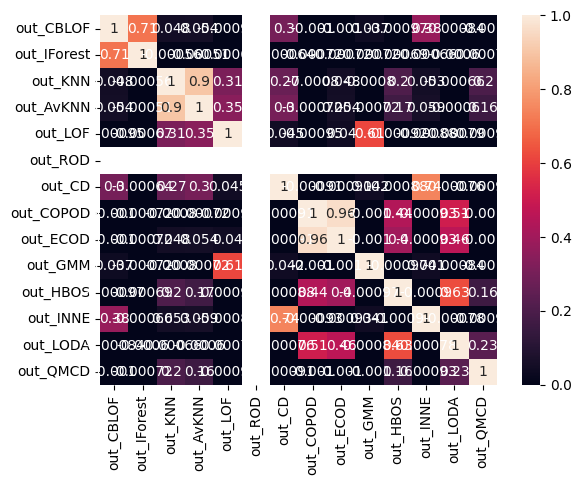

In [105]:
ax = sns.heatmap(df_small[out_algos].corr(), annot=True)
# pearson correlation between different algorithms - this tells us 
# which algorithms are returning similar results

In [34]:
df_small[out_algos].corr(method='pearson')
#This tells us which algorithms are similar i.e. detecting the same row as outlier

,out_CBLOF,out_IForest,out_KNN,out_AvKNN,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD
out_CBLOF,1.000000,0.706928,0.048274,0.053718,-0.000953,NaN,0.298936,-0.001014,-0.001014,0.037487,-0.000974,0.375729,-0.000843,-0.001014
out_IForest,0.706928,1.000000,-0.000562,-0.000507,-0.000674,NaN,-0.000644,-0.000717,-0.000717,-0.000717,-0.000688,-0.000659,-0.000596,-0.000717
out_KNN,0.048274,-0.000562,1.000000,0.901335,0.312262,NaN,0.272255,-0.000795,0.048274,-0.000795,0.203519,0.052608,-0.000661,0.195482
out_AvKNN,0.053718,-0.000507,0.901335,1.000000,0.346558,NaN,0.302170,-0.000717,0.053718,-0.000717,0.169276,0.058512,-0.000596,0.162586
out_LOF,-0.000953,-0.000674,0.312262,0.346558,1.000000,NaN,0.044684,-0.000953,0.039979,0.613028,-0.000916,-0.000877,-0.000793,-0.000953
out_ROD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
out_CD,0.298936,-0.000644,0.272255,0.302170,0.044684,NaN,1.000000,-0.000911,-0.000911,0.041924,-0.000875,0.744173,-0.000758,-0.000911
out_COPOD,-0.001014,-0.000717,-0.000795,-0.000717,-0.000953,NaN,-0.000911,1.000000,0.961499,-0.001014,0.439808,-0.000932,0.508068,-0.001014
out_ECOD,-0.001014,-0.000717,0.048274,0.053718,0.039979,NaN,-0.000911,0.961499,1.000000,-0.001014,0.399737,-0.000932,0.461803,-0.001014
out_GMM,0.037487,-0.000717,-0.000795,-0.000717,0.613028,NaN,0.041924,-0.001014,-0.001014,1.000000,-0.000974,0.040919,-0.000843,-0.001014


In [108]:
# All model vote columns
out_algos = [c for c in df.columns if c.startswith('out_')]

# Sum of "outlier" votes per row
df['rank'] = df[out_algos].sum(axis=1)
df

,eventid,timestamp,sourceIPAddress,eventSource,eventName,userAgent,userIdentity.arn,tactic1,tactic2,out_CBLOF,...,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,rank
0,1001,2018-09-25T12:06:16.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
1,1002,2018-09-25T12:06:16.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
2,1003,2018-09-25T12:41:50.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
3,1004,2018-09-25T12:26:18.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
4,1005,2018-09-25T12:31:50.000Z,46,18,1,27,0,Credential Access,Lateral Movement,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,26672,2018-12-20T22:12:06.000Z,15,5,72,24,1,Execution,-,0,...,0,0,0,0,0,0,0,0,0,0
25671,26673,2018-09-26T19:45:33.000Z,15,5,73,24,1,Execution,-,1,...,0,0,0,0,0,0,0,0,0,1
25672,26674,2018-12-18T21:47:24.000Z,15,5,73,24,1,Execution,-,1,...,0,0,0,0,0,0,0,0,0,1
25673,26675,2018-12-18T21:45:59.000Z,15,5,73,24,1,Execution,-,1,...,0,0,0,0,0,0,0,0,0,1


In [110]:
# scored anomalies in the encoded dataframe
#anomalies_scored = df[df['rank'] > 0].copy()
# scored rows (encoded df)
anomalies_scored = df[df['rank'] > 0][['eventid', 'rank'] ].copy()

# list of GUIDs that were flagged
anomalous_eventids = anomalies_scored['eventid'].unique()

# pull original CloudTrail rows based on GUIDs
ddf = raw[raw['eventid'].isin(anomalous_eventids)].copy()

# optional: keep rank and votes attached by merging back on eventid
ddf = ddf.merge(
    df[['eventid', 'rank'] + out_algos],
    on='eventid',
    how='left',
    suffixes=('', '_score')
)
pd.set_option('display.max_rows', 135)
pd.set_option('display.max_colwidth', None)
ddf

,eventid,timestamp,sourceIPAddress,eventSource,eventName,userAgent,userIdentity.arn,tactic1,tactic2,rank,...,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD
0,22741,2018-09-26T18:09:00.000Z,198.18.161.170,billingconsole.amazonaws.com,AWSPaymentInstrumentGateway.Delete,Null,arn:aws:iam::123456789012:root,Defense Evasion,-,4,...,1,0,0,0,1,0,0,0,0,0
1,22742,2018-09-28T13:39:07.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4311831040),arn:aws:iam::123456789012:root,Persistence,Initial Access,5,...,0,0,1,0,0,0,0,1,0,0
2,22743,2018-09-27T15:28:29.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4320147968),arn:aws:iam::123456789012:root,Persistence,Initial Access,4,...,0,0,1,0,0,1,0,1,0,0
3,22744,2018-09-30T17:30:21.000Z,223.0.113.35,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4328573952),arn:aws:iam::123456789012:root,Persistence,Initial Access,3,...,0,0,1,0,0,0,0,1,0,0
4,22745,2018-09-29T13:58:43.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (5637278720),arn:aws:iam::123456789012:root,Persistence,Initial Access,2,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,26666,2018-12-29T19:10:08.000Z,198.18.161.170,billingconsole.amazonaws.com,RedeemPromoCode,Null,arn:aws:iam::123456789012:root,Defense Evasion,-,2,...,0,0,0,1,1,0,0,0,0,0
135,26673,2018-09-26T19:45:33.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1,...,0,0,0,0,0,0,0,0,0,0
136,26674,2018-12-18T21:47:24.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1,...,0,0,0,0,0,0,0,0,0,0
137,26675,2018-12-18T21:45:59.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1,...,0,0,0,0,0,0,0,0,0,0


In [112]:
out_algos = [c for c in df.columns if c.startswith('out_')]
df['rank'] = df[out_algos].sum(axis=1)
rank_lookup = df.loc[df['rank'] > 0, ['eventid', 'rank']]
ddf = raw.merge(
    rank_lookup,
    on='eventid',
    how='inner'
)
assert ddf['rank'].gt(0).all()
ddf

,eventid,timestamp,sourceIPAddress,eventSource,eventName,userAgent,userIdentity.arn,tactic1,tactic2,rank
0,22741,2018-09-26T18:09:00.000Z,198.18.161.170,billingconsole.amazonaws.com,AWSPaymentInstrumentGateway.Delete,Null,arn:aws:iam::123456789012:root,Defense Evasion,-,4
1,22742,2018-09-28T13:39:07.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4311831040),arn:aws:iam::123456789012:root,Persistence,Initial Access,5
2,22743,2018-09-27T15:28:29.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4320147968),arn:aws:iam::123456789012:root,Persistence,Initial Access,4
3,22744,2018-09-30T17:30:21.000Z,223.0.113.35,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4328573952),arn:aws:iam::123456789012:root,Persistence,Initial Access,3
4,22745,2018-09-29T13:58:43.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (5637278720),arn:aws:iam::123456789012:root,Persistence,Initial Access,2
...,...,...,...,...,...,...,...,...,...,...
134,26666,2018-12-29T19:10:08.000Z,198.18.161.170,billingconsole.amazonaws.com,RedeemPromoCode,Null,arn:aws:iam::123456789012:root,Defense Evasion,-,2
135,26673,2018-09-26T19:45:33.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1
136,26674,2018-12-18T21:47:24.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1
137,26675,2018-12-18T21:45:59.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1


In [114]:
assert raw['eventid'].is_unique, \
    "Duplicate eventid detected between raw and ddf"
assert ddf['eventid'].is_unique, \
    "Duplicate eventid detected between raw and ddf"
print("no duplicate event ids")

no duplicate event ids


In [54]:
ddf

,eventid,timestamp,sourceIPAddress,eventSource,eventName,userAgent,userIdentity.arn,tactic1,tactic2,rank
0,22741,2018-09-26T18:09:00.000Z,198.18.161.170,billingconsole.amazonaws.com,AWSPaymentInstrumentGateway.Delete,Null,arn:aws:iam::123456789012:root,Defense Evasion,-,4
1,22742,2018-09-28T13:39:07.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4311831040),arn:aws:iam::123456789012:root,Persistence,Initial Access,5
2,22743,2018-09-27T15:28:29.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4320147968),arn:aws:iam::123456789012:root,Persistence,Initial Access,4
3,22744,2018-09-30T17:30:21.000Z,223.0.113.35,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (4328573952),arn:aws:iam::123456789012:root,Persistence,Initial Access,3
4,22745,2018-09-29T13:58:43.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 iPad5-3 (5637278720),arn:aws:iam::123456789012:root,Persistence,Initial Access,2
...,...,...,...,...,...,...,...,...,...,...
134,26666,2018-12-29T19:10:08.000Z,198.18.161.170,billingconsole.amazonaws.com,RedeemPromoCode,Null,arn:aws:iam::123456789012:root,Defense Evasion,-,2
135,26673,2018-09-26T19:45:33.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1
136,26674,2018-12-18T21:47:24.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1
137,26675,2018-12-18T21:45:59.000Z,198.18.161.170,ec2.amazonaws.com,StartInstances,console.ec2.amazonaws.com,arn:aws:iam::123456789012:root,Execution,-,1


In [116]:
# check that the event IDs match between the raw and scored data rows
ts_check = (
    raw[['eventid', 'timestamp']]
    .merge(
        ddf[['eventid', 'timestamp']],
        on='eventid',
        how='inner',
        suffixes=('_raw', '_ddf')
    )
)
ts_check['timestamp_match'] = (
    ts_check['timestamp_raw'] == ts_check['timestamp_ddf']
)
ts_check['timestamp_match'].value_counts()



timestamp_match
True    139
Name: count, dtype: int64

In [ ]:
import pandas as pd
from ipywidgets import Dropdown, VBox, HBox, Output, interactive_output

def make_filter_ui(df, filter_cols=None, max_unique=50):
    """
    Build an interactive filter UI for a DataFrame.

    - If filter_cols is None, automatically choose columns with
      1 < nunique <= max_unique.
    - max_unique controls how 'wide' a dropdown can be before we skip it.
    """
    # Auto-discover filterable columns if none provided
    if filter_cols is None:
        auto_cols = []
        for col in df.columns:
            # dropna=True so we're counting real values
            nunique = df[col].nunique(dropna=True)
            if 1 < nunique <= max_unique:
                auto_cols.append(col)

        filter_cols = auto_cols

    if not filter_cols:
        print("No suitable columns found for dropdown filters.")
        return

    print("Using filter columns:", filter_cols)

    # Create one dropdown per filter column
    dropdowns = {}
    for col in filter_cols:
        values = df[col].dropna().astype(str).unique()
        values_sorted = sorted(values)
        options = ['(All)'] + values_sorted

        dropdowns[col] = Dropdown(
            options=options,
            value='(All)',
            description=col,
            layout={'width': '400px'}
        )

    out = Output()

    def filter_df(**kwargs):
        with out:
            out.clear_output()
            mask = pd.Series(True, index=df.index)

            for col, selected in kwargs.items():
                if selected != '(All)':
                    mask &= df[col].astype(str).eq(selected)

            filtered = df[mask]
            display(filtered.head(100))
            print(f"\nShowing {min(len(filtered), 100)} of {len(filtered)} matching rows.")

    interactive = interactive_output(
        filter_df,
        {col: dropdowns[col] for col in filter_cols}
    )

    controls_box = VBox(list(dropdowns.values()))
    ui = VBox([controls_box, out])

    display(ui, interactive)

# Call this once to build the UI (auto-discover columns)
make_filter_ui(ddf)

# Or, if you ever want to force a specific set:
# make_filter_ui(ddf, filter_cols=['source', 'action', 'arn', 'tactic1', 'tactic2'])
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_colwidth', None)

In [66]:

from ipywidgets import (
    Checkbox,
    IntText,
    Dropdown,
    VBox,
    HBox,
    Output,
    Button,
    HTML,
    Layout,
)
from IPython.display import display

def make_groupby_ui(df):
    """
    Interactive UI to group/aggregate a DataFrame by selected fields and show counts.

    - Column discovery is dynamic
    - Group-by fields selected via checkboxes
    - Aggregation runs only when button is pressed
    """

    all_cols = list(df.columns)

    # --- Column checkboxes ---
    col_checkboxes = {
        col: Checkbox(
            value=False,
            description=col,
            indent=False,
            layout=Layout(width="280px"),
        )
        for col in all_cols
    }

    # Arrange checkboxes in rows
    rows = []
    cols_per_row = 3
    items = list(col_checkboxes.values())
    for i in range(0, len(items), cols_per_row):
        rows.append(HBox(items[i:i + cols_per_row]))
    checkboxes_box = VBox(rows)

    # --- Controls ---
    sort_widget = Dropdown(
        options=["count ↓ (desc)", "count ↑ (asc)"],
        value="count ↑ (asc)",
        description="Sort",
        layout={"width": "220px"},
    )

    top_n_widget = IntText(
        value=50,
        description="Top N",
        layout={"width": "150px"},
    )

    run_button = Button(
        description="Run aggregation",
        button_style="primary",
        tooltip="Compute group-by counts",
    )

    out = Output()

    # --- Aggregation logic (runs on button click) ---
    def run_aggregation(_):
        with out:
            out.clear_output()

            group_by = [col for col, cb in col_checkboxes.items() if cb.value]

            if not group_by:
                display(HTML("<b>Please select at least one field to group by.</b>"))
                return

            agg = (
                df
                .groupby(group_by)
                .size()
                .reset_index(name="count")
            )

            ascending = (sort_widget.value == "count ↑ (asc)")
            agg = agg.sort_values("count", ascending=ascending)

            if top_n_widget.value and top_n_widget.value > 0:
                agg_display = agg.head(top_n_widget.value)
            else:
                agg_display = agg

            display(agg_display)
            print(
                f"\nShowing {len(agg_display)} of {len(agg)} group rows "
                f"(grouped by {', '.join(group_by)})."
            )

    run_button.on_click(run_aggregation)

    # --- Layout ---
    controls_box = VBox([
        HTML("<b>Select fields to group by:</b>"),
        checkboxes_box,
        HBox([sort_widget, top_n_widget, run_button]),
    ])

    ui = VBox([controls_box, out])
    display(ui)

# Example usage
pd.set_option('display.max_rows', 35)
pd.set_option('display.max_colwidth', None)
make_groupby_ui(ddf)
